# How to Create an N-Gram Model from Scratch

```yaml
Course:  DS 5001
Module:  M03 Language Models
Topic:   How to Create an N-Gram Model from Scratch
Author:  R.C. Alvarado
Date:    6 February 2023
```

**Purpose**: To demonstrate how a simple ngram language models are created from data and applied to the prediction of sentences. No effort is made to define classes or functions; instead the code is meant to show the logic as clearly as possible.

## Pattern

1. Import corpus &rarr; `TOKEN`, `VOCAB`.
2. Extract ngrams from training tokens &rarr; `NGRAM`.
3. Count ngrams and convert to models &rarr; `MODEL`.
4. Convert test sentences into tokens &rarr; `TEST_SENT`, `TEST_TOKEN`.
5. Extract ngrams from test tokens &rarr; `TEST_NGRAM`.
6. Test model by joining model information `M.i` to `TEST_NGRAM` and then summing i per sentence &rarr; `TEST_NGRAM'`, `TEST_SENT'`.
7. Compute model perplexity by exponentiating mean information. 

# Set Up Environment

In [1]:
import pandas as pd
import numpy as np

In [2]:
import configparser
config = configparser.ConfigParser()
config.read("../../../env.ini")
data_dir = config['DEFAULT']['data_home']
output_dir = config['DEFAULT']['output_dir']

In [3]:
output_dir

'/home/rca2t/Documents/MSDS/DS5001/output'

In [4]:
ngrams = 3
widx = [f"w{i}" for i in range(ngrams)]

In [5]:
widx

['w0', 'w1', 'w2']

# Get Some Training Data

In [6]:
data_dir = output_dir
OHCO = ['book_id','chap_num','para_num','sent_num','token_num']

In [7]:
TOKEN = pd.read_csv(data_dir + "/austen-combo-TOKENS.csv").set_index(OHCO)
VOCAB = pd.read_csv(data_dir + "/austen-combo-VOCAB.csv").set_index('term_str')

In [8]:
TOKEN.head()

token_str  term_str
book_id chap_num para_num sent_num token_num                    
1       1        0        0        0               Sir       sir
                                   1            Walter    walter
                                   2            Elliot    elliot
                                   3                of        of
                                   4          Kellynch  kellynch

In [9]:
VOCAB.head()

,n
term_str,
1,3
15,1
16,1
1760,1
1784,1


# Select OOV terms

For our OOV terms, we select very short words that appear only once.

This is just one way to handle OOV terms.

In [10]:
VOCAB['n_chars'] = VOCAB.index.str.len()
VOCAB['modified_term_str'] = VOCAB.index
VOCAB.loc[(VOCAB.n == 1) & (VOCAB.n_chars < 3), 'modified_term_str'] = "<UNK>"

In [11]:
VOCAB

,n,n_chars,modified_term_str
term_str,,,
1,3,1,1
15,1,2,<UNK>
16,1,2,<UNK>
1760,1,4,1760
1784,1,4,1784
...,...,...,...
youthful,3,8,youthful
z,1,1,<UNK>
zeal,7,4,zeal


We apply the modified term list to our tokens.

In [12]:
TOKEN['modified_term_str'] = TOKEN.term_str.map(VOCAB.modified_term_str)

In [13]:
TOKEN[TOKEN.modified_term_str == '<UNK>'].sample(5)

token_str term_str  \
book_id chap_num para_num sent_num token_num                      
2       39       18       10       11                L        l   
1       23       40       2        0                 E        e   
        1        3        1        27               16       16   
        17       8        20       10               au       au   
        21       71       4        13               Wm       wm   

                                             modified_term_str  
book_id chap_num para_num sent_num token_num                    
2       39       18       10       11                    <UNK>  
1       23       40       2        0                     <UNK>  
        1        3        1        27                    <UNK>  
        17       8        20       10                    <UNK>  
        21       71       4        13                    <UNK>

# Generate NGram Models

Here, we want to take our list of modified tokens and add sentence boundary symbols `<s>` and `</s>` before and after each sentence.

Then we want to bind offset versions of the this token list into a dataframe with as many columns as our ngram is wide.

So, for example, for a trigram table representing the novle _Emma_, we want something like this:

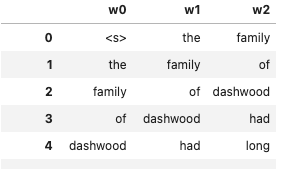

Note how each succussive column is the same data but shifted up one row.

Note also that this table contains all the data required to count instances of trigrams and all lower-order n-grams, i.e. bigram and unigram.

## Prepare tokens for ngram binding

We assign an absolute sentence number to each inital token and then label all the tokens in a given sentence by their sentence number.

We must do this because the current `sent_num` index column refers to the order of the sentence within the paragraph.

We want the order of the sentence within the corpus.

In [14]:
def token_to_padded(token, grouper=['sent_num'], term_str='term_str'):
    ohco = token.index.names # We preserve these since they get lost in the shuffle
    padded = token.groupby(grouper)\
        .apply(lambda x: '<s> ' + ' '.join(x[term_str]) + ' </s>')\
        .apply(lambda x: pd.Series(x.split()))\
        .stack().to_frame('term_str')
    padded.index.names = ohco
    return padded

In [15]:
PADDED = token_to_padded(TOKEN, grouper=OHCO[:4], term_str='modified_term_str')

In [16]:
PADDED.head()

term_str
book_id chap_num para_num sent_num token_num         
1       1        0        0        0              <s>
                                   1              sir
                                   2           walter
                                   3           elliot
                                   4               of

## Bind modified token sequence into an ngram table 

Next, we choose the maximum ngram length for our models.

Now we concatenate a set of offset versions of our token list. 

We use the `df.shift()` method to offset our token list for each position in the resulting ngram list.

Then we use the `pd.concat()` method to bind our offset token lists.

In [17]:
# T = PADDED.groupby(OHCO[:4]).apply(lambda x: pd.concat([x.shift(0-i) for i in range(ngrams)], axis=1)).reset_index(drop=True)
# T.index = PADDED.index
# T.columns = widx

In [18]:
# T.loc[(1,1,0,2)]

In [19]:
def padded_to_ngrams(padded, grouper=['sent_num'], n=2):
    
    ohco = padded.index.names
    ngrams = padded.groupby(grouper)\
        .apply(lambda x: pd.concat([x.shift(0-i) for i in range(n)], axis=1))\
        .reset_index(drop=True)
    ngrams.index = padded.index
    ngrams.columns = widx

    # ngrams = pd.concat([padded.shift(0-i) for i in range(n)], axis=1)
    # ngrams.index.name = 'ngram_num'
    # ngrams.columns = widx
    # ngrams = ngrams.fillna('<EOF>')
    
    return ngrams

In [20]:
NGRAMS = padded_to_ngrams(PADDED, OHCO[:4], ngrams)

In [21]:
NGRAMS

w0        w1        w2
book_id chap_num para_num sent_num token_num                                 
1       1        0        0        0                  <s>       sir    walter
                                   1                  sir    walter    elliot
                                   2               walter    elliot        of
                                   3               elliot        of  kellynch
                                   4                   of  kellynch      hall
...                                                   ...       ...       ...
2       50       22       0        10         sensibility        by      jane
                                   11                  by      jane    austen
                                   12                jane    austen      </s>
                                   13              austen      </s>      None
                                   14                </s>      None      None

[230426 rows x 3 columns]

## Generate models

Next we create a list of models. 

Since the model index will be zero-based (given Python), the trigram model will be `M[2]`, for example. 

We can use the maximum ngram table to derive all of the lower order models.

For each model, we will compute the relevant probabilities and information for each ngram.

In [100]:
def ngrams_to_models(ngrams):
    global widx
    n = len(ngrams.columns)
    model = [None for i in range(n)]
    for i in range(n):
        if i == 0:
            model[i] = ngrams.value_counts('w0').to_frame('n')
            model[i]['p'] = model[i].n / model[i].n.sum()
            model[i]['i'] = np.log2(1/model[i].p)
        else:
            model[i] = ngrams.value_counts(widx[:i+1]).to_frame('n')    
            model[i]['cp'] = model[i].n / model[i-1].n
            model[i]['i'] = np.log2(1/model[i].cp)
        model[i] = model[i].sort_index()
    return model

In [101]:
M = ngrams_to_models(NGRAMS)

In [102]:
M[2]

n   cp    i
w0        w1          w2                   
1         1760        married   1  1.0  0.0
          1785        </s>      1  1.0  0.0
          ends        </s>      1  1.0  0.0
1760      married     july      1  1.0  0.0
1784      elizabeth   daughter  1  1.0  0.0
...                            ..  ...  ...
zealous   attention   as        1  1.0  0.0
          officer     too       1  1.0  0.0
          on          the       1  1.0  0.0
zealously active      as        1  1.0  0.0
          discharging all       1  1.0  0.0

[157800 rows x 3 columns]

# Test Models

## Generate Training Data

Import and pad the test sentences.

In [103]:
def sentence_to_token(sent_list, file=True):
    
    # Convert list of sentences to dataframe
    if file:
        S = pd.read_csv("test_sentences.txt", header=None, names=['sent_str'])
    else:
        S = pd.DataFrame(sent_list, columns=['sent_str'])
    S.index.name = 'sent_num'
    
    # Convert dataframe of sentences to TOKEN with normalized terms
    K = S.sent_str.apply(lambda x: pd.Series(x.split())).stack().to_frame('token_str')
    K['term_str'] = K.token_str.str.replace(r"[\W_]+", "", regex=True).str.lower()
    K.index.names = ['sent_num', 'token_num']
    
    return S, K

In [104]:
TEST_SENTS, TEST_TOKENS = sentence_to_token("test_sentences.txt")

In [105]:
TEST_SENTS.head()

,sent_str
sent_num,
0,the quick brown fox jumped over the lazy dogs
1,The event had every promise of happiness for h...
2,Mr Weston was a man of unexceptionable charact...
3,ChatGPT is not the singularity
4,but it was a black morning's work for her


In [106]:
TEST_TOKENS.head()

token_str term_str
sent_num token_num                   
0        0               the      the
         1             quick    quick
         2             brown    brown
         3               fox      fox
         4            jumped   jumped

## Identify OOV terms

Create a Series of OOV terms from our unigram model.

This could be included in our function.

In [107]:
TEST_TOKENS.loc[~TEST_TOKENS.term_str.isin(M[0].index), 'term_str'] = "<UNK>"

In [108]:
TEST_TOKENS[TEST_TOKENS.term_str == '<UNK>'].value_counts('token_str')

token_str
Weston            2
ChatGPT           1
Hartfield         1
Isabella          1
Isabella's        1
Woodhouse         1
childhood         1
illnesses         1
intellectual      1
lazy              1
tenderer          1
valetudinarian    1
Name: count, dtype: int64

## Convert test tokens into ngrams

Use offset and bind method using `pd.concat()` and `df.shift(0)`, as above.

In [109]:
TEST_PADDED = token_to_padded(TEST_TOKENS)

In [110]:
TEST_PADDED.head()

term_str
sent_num token_num         
0        0              <s>
         1              the
         2            quick
         3            brown
         4              fox

In [111]:
TEST_NGRAMS = padded_to_ngrams(TEST_PADDED, 'sent_num', ngrams)

In [112]:
TEST_NGRAMS.loc[0]

,w0,w1,w2
token_num,,,
0,<s>,the,quick
1,the,quick,brown
2,quick,brown,fox
3,brown,fox,jumped
4,fox,jumped,over
5,jumped,over,the
6,over,the,<UNK>
7,the,<UNK>,dogs
8,<UNK>,dogs,</s>


## Bind the models to test data

We add our model data to the test data as a set of features.

In [113]:
def test_model(model, ngrams, sents):
    
    global widx
    
    assert len(model) == len(ngrams.columns)
    
    n = len(model)
    ohco = ngrams.index.names
    
    R = []
    for i in range(n):
        T = ngrams.merge(M[i], on=widx[:i+1], how='left')
        T.index = ngrams.index
        T = T.reset_index().set_index(ohco + widx).i #.to_frame(f"i{i}")
        
        # This how we handle unseen combos
        T[T.isna()] = T.max()
        R.append(T.to_frame(f"i{i}"))
                
    return pd.concat(R, axis=1)

In [114]:
R = test_model(M,TEST_NGRAMS, TEST_SENTS)

In [115]:
def compute_perplexity(results, test_sents, n=3):
    for i in range(n):
        test_sents[f"pp{i}"] = np.exp2(results.groupby('sent_num')[f"i{i}"].mean())
    return test_sents

In [116]:
PP = compute_perplexity(R, TEST_SENTS)

In [117]:
PP

,sent_str,pp0,pp1,pp2
sent_num,,,,
0,the quick brown fox jumped over the lazy dogs,2290.934685,2309.499291,708.500000
1,The event had every promise of happiness for h...,234.139334,178.220932,393.650320
2,Mr Weston was a man of unexceptionable charact...,1037.091158,892.111192,446.847922
3,ChatGPT is not the singularity,360.995699,1388.464294,412.778507
4,but it was a black morning's work for her,353.927354,241.534050,134.554172
5,The want of Miss Taylor would be felt every ho...,339.694301,172.165958,125.188203
6,She recalled her past kindness the kindness th...,520.836197,539.547828,318.795801
7,how she had taught and how she had played with...,365.827823,188.118381,236.265962
8,how she had devoted all her powers to attach a...,414.267207,260.791658,467.034179


In [118]:
# T0 = TEST_NGRAMS.merge(M[0], on=['w0'], how='left')
# T0.index = TEST_NGRAMS.index
# TEST_SENTS['pp0'] = np.exp2(T0.groupby('sent_num').i.mean())

# T1 = TEST_NGRAMS.merge(M[1], on=['w0','w1'], how='left')
# T1.index = TEST_NGRAMS.index
# TEST_SENTS['pp1']= np.exp2(T1.groupby('sent_num').ci.mean())

# T2 = TEST_NGRAMS.merge(M[2], on=['w0','w1','w2'], how='left')
# T2.index = TEST_NGRAMS.index
# TEST_SENTS['pp2']= np.exp2(T2.groupby('sent_num').ci.mean())

# Model Perplexity

In [206]:
# R.groupby('sent_num').mean().mean().plot.bar();

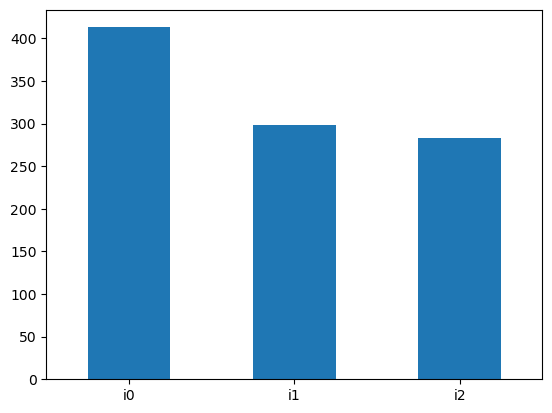

In [207]:
np.exp2(R.mean()).plot.bar(rot=0);

In [120]:
PP.iloc[:,1:].corr().style.background_gradient(axis=None)

,pp0,pp1,pp2
pp0,1.000000,0.797940,0.594335
pp1,0.797940,1.000000,0.628315
pp2,0.594335,0.628315,1.000000


In [121]:
# PP.iloc[:,1:].corr().unstack().sort_values(ascending=False).reset_index().query("level_0 < level_1").set_index(['level_0','level_1'])

# Visualize

In [122]:
Z = TEST_SENTS.copy()
Z['sent_str'] = Z.sent_str.str.replace('<s> ', '').str.replace(' </s>', '')
Z = Z.set_index('sent_str')
Z = (Z - Z.mean()) / Z.std()

In [123]:
Z['pp_mean'] = Z.mean(axis=1) # Just for sorting purposes

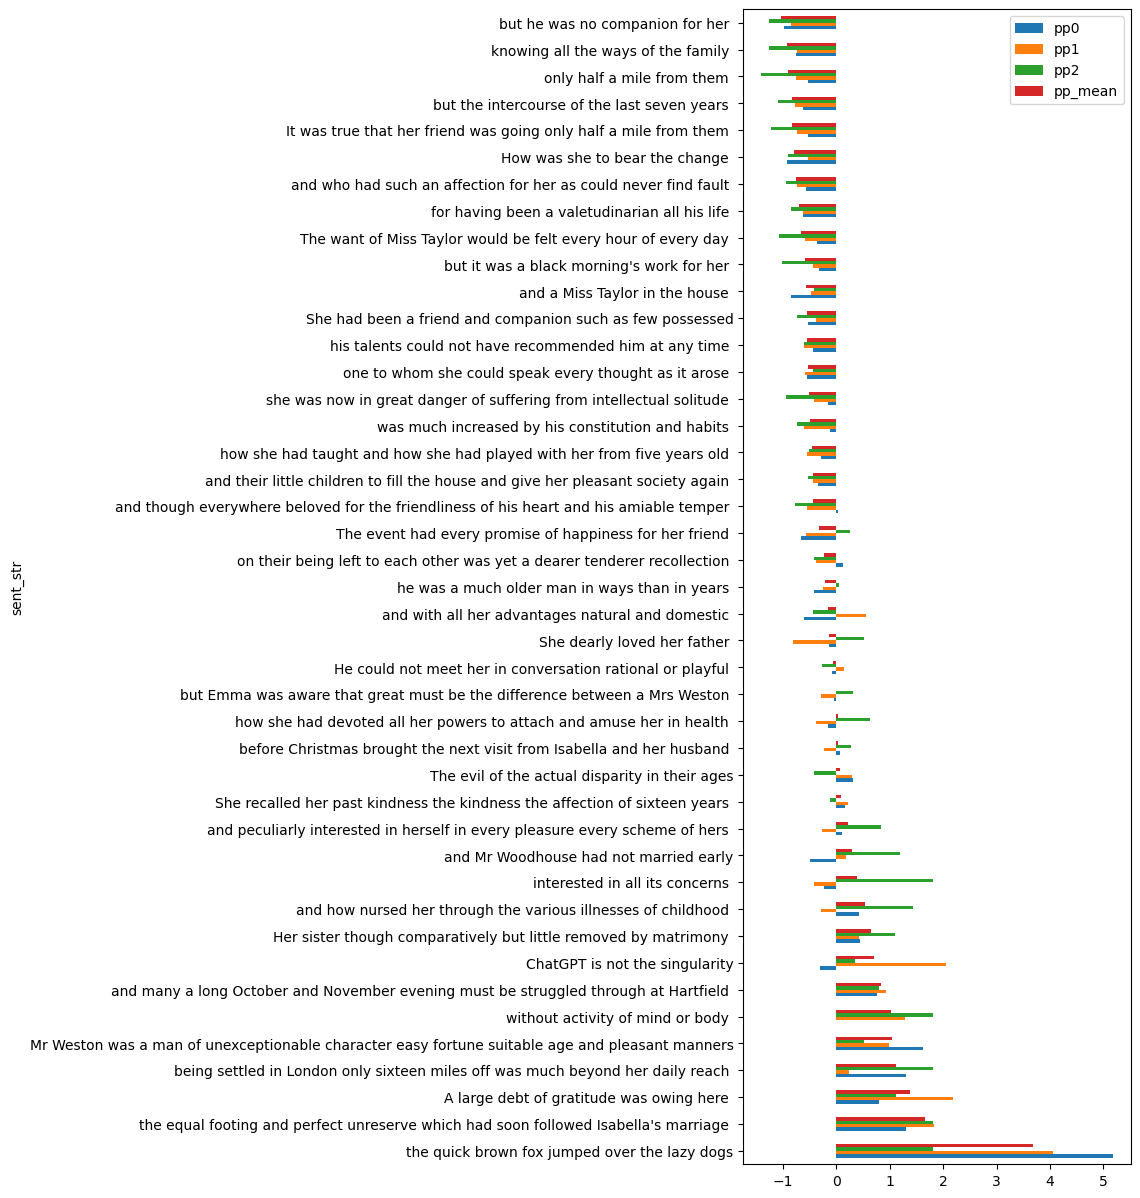

In [124]:
Z.sort_values('pp_mean', ascending=False).plot.barh(figsize=(5,15));

# Generate Text

In [1]:
def generate_text(M, n=250):
    
    if len(M) < 3:
        raise ValueError("Must have trigram model generated.")
    
    # Start list of words
    first_word = M[1].loc['<s>'].sample(weights='cp').index[0]
    
    words = ['<s>', first_word]
    
    for i in range(n):
        
        bg = tuple(words[-2:])

        # Try trigram model
        try:
            next_word = M[2].loc[bg].sample(weights='cp').index[0]

        # If not found in model, back off ...
        except KeyError as e1:
            try:
                # Get the last word in the bigram
                ug = bg[1]
                next_word = M[1].loc[ug].sample(weights='cp').index[0]
            
            except KeyError as e2:
                next_word = M[0].sample(weights='p').index[0]
                
        words.append(next_word)
    
    
    text = ' '.join(words[2:])
    print('\n\n'.join([str(i+1) + ' ' + line.replace('<s>','')\
        .strip().upper() for i, line in enumerate(text.split('</s>'))]))

In [191]:
generate_text(M)

1 COULD HAVE NO ORIGIN BUT IN THE STAGE I ASSURE YOU AND ONLY BE SORRY TO HAVE IT DONE WITH THAT PROPERTY COULD BE IN TOWN AND RETURN AT NIGHT

2 YOU KNOW IS A MOST ELIGIBLE CONNECTION FOR LIFE WITH AN INTEREST TO THE PLAN AND ALL SEEMING EQUALLY INDIFFERENT DURING THE NEXT SUMMER WHEN I WANTED

3 ADMIRAL WITH SYMPATHETIC CORDIALITY OBSERVED TO HIS FORMER CAPTAIN TO CAPTAIN AND MRS

4 PARK SHE LAUGHED AT THE OPINION OF IT OFTEN BECOMES A PLEASURE TO CALL FOR ASSISTANCE

5 WITH A KIND BOW TO ANNE ALONE

6 SEEMS TO IMPLY MORE

7 INSIPIDITY OF THE DAY OF GENERAL ADMIRATION AND REGARD EVEN HER EYES BUT FOR THIS WALK AND THEY MET EVERY MORNING AND MUST NOW BE MADE ON IT AT ALL

8 THERE IS NOT VERY CONVENIENTLY HAVE LEFT ALMOST EVERYTHING TO HENRIETTA

9 COMFORT OF THE LITTLE BOYS SHE WAS EXACTLY LIKE EVERY OTHER RESPECT IN LOOKING AROUND HER

10 IT WAS GONE BY

11 ON MERELY HEARING THE NAME OF WILLOUGHBY IF YOU SHOULD SUSPECT WHAT WAS GOING ON WELL OR THAT THERE WAS NO MATERIAL DANGER IN FA